<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/BERT/BERTimbau_com_amostras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers

     |████████████████████████████████| 2.6 MB 8.3 MB/s 
     |████████████████████████████████| 3.3 MB 57.0 MB/s 
     |████████████████████████████████| 895 kB 48.7 MB/s 
     |████████████████████████████████| 636 kB 65.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:

!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.


     |████████████████████████████████| 804.1 MB 2.8 kB/s 
     |████████████████████████████████| 17.4 MB 118 kB/s 
     |████████████████████████████████| 1.9 MB 61.5 MB/s 
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to:
1. loosen the range of package versions you'

In [3]:
!nvidia-smi

Sun Aug 15 13:37:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive
import io, os

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score
import seaborn as sns

### Carregando tokens e vocabulário do BERTimbau

In [5]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

### Preparando DataSet
https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [6]:
#!rm *.csv
#!!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/train.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/valid.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/test.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/miscelanea.csv
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks
path = '/gdrive/My Drive/Colab Notebooks'
KEY='4/1AX4XfWjFfXOpQF_Lhhwz8Sp5DTauJAEXNDQjx66Khyme5ASsCvDLtcqsBX0'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [ ]:
#%cd amostra_news_integrada
#!unzip drive-download-20210731T211249Z-001.zip
#!ls -lh

#!mkdir bertimbau_all_categ


In [ ]:
#!mkdir ./bertimbau_all_categ/amostra_4


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
source_folder = './amostra_news_integrada/amostra_' #'/content'
destination_folder = './bertimbau_resp' #'/content'


In [9]:
!ls 

 amostra_news_integrada		       'Cópia de BERTimbau_Testes (3).ipynb'
 artigosWikibr.ipynb		       'Cópia de BERTimbau_Testes.ipynb'
 BERTimbau_com_amostras.ipynb	        news_integradas.csv
 bertimbau_resp			        Untitled
'Cópia de BERTimbau_Testes (1).ipynb'   Untitled1.ipynb
'Cópia de BERTimbau_Testes (2).ipynb'


In [10]:
#https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
#Model hyper-parameter
MAX_SEQ_LEN = 128 #limita os artigos em 128 tokens. BERTimbau base é limitado em 512 tokens por texto.
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
bs = 16
lr = 1e-5



# Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('label', label_field)]





In [11]:
def tokenizaAmostra(source_folder, fields=fields):
  # TabularDataset
  train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                            test='test.csv', format='CSV', fields=fields, skip_header=True)
  # Iterators

  train_iter = BucketIterator(train, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  valid_iter = BucketIterator(valid, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  test_iter = Iterator(test, batch_size=bs, device=device, train=False, shuffle=False, sort=False)
  return [train_iter, valid_iter, test_iter]



In [ ]:
#print(vars(train[0]))
#print(vars(valid[0]))
#print(vars(test[0]))

## Modelo

In [12]:
'''É preciso informar o número de labels '''
class BERT(nn.Module):

    def __init__(self, qtd_categories):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',num_labels=qtd_categories )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea



## Treinamento

In [13]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def create_directory(path, directory):
  try:
    os.makedirs(path + '/' + directory)
  except FileExistsError:
    # directory already exists
    pass

In [14]:
# Training Function
'''criterion = nn.BCELoss() é BinaryCrossEntropy é a função de perda para targets binarios. Como o nosso alvo possui
muitas classes troque a função de perda para nn.CrossEntropyLoss() '''

def train(model,
          optimizer,
          train_loader ,
          valid_loader ,
          eval_every ,
          file_path ,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          num_epochs = 5,
          best_valid_loss = float("Inf")):
    
    
    print('1 - inicializando variávies')
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    print('1 - inicializando treinamento')
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            #print('label size:', labels.size())
            #print('label:', labels)
            labels = labels.to(device)
            text = text.type(torch.LongTensor) 
            #print('text:', text.size())
            text = text.to(device)
            #print('treina...')
            output = model(text, labels)
            #print('fim treino...')
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text,labels), _ in valid_loader:
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
%%time
qtd_categories=[32]
#token_train, token_valid, token_test = [],[],[]
id_planilha = [7]
dataset = [1]
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
  create_directory(destination_folder,str(id_))
  file_path = destination_folder + "/"+str(id_)
  print(file_path)
  model = BERT(qtd_categories=qtd_categories[idx]).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  inicio = datetime.now()
  print('Treinando amostra:', amostra, 'inicio:', inicio)
  tokens = tokenizaAmostra(source_folder+str(amostra))
  #token_train.append(tokens[0])
  #token_valid.append(tokens[1])
  #token_test.append(tokens[2])
  train(model=model, 
      optimizer=optimizer,
      num_epochs=10,
      train_loader=tokens[0],
      valid_loader=tokens[1],
      eval_every=len(tokens[0]) // 2,
      file_path=file_path)
  print('Duracao:', datetime.now()-inicio)

./bertimbau_resp/7


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 1 inicio: 2021-08-12 23:36:28.066038
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/10], Step [80/1600], Train Loss: 3.3831, Valid Loss: 3.3216
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [1/10], Step [160/1600], Train Loss: 3.2339, Valid Loss: 3.0489
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [2/10], Step [240/1600], Train Loss: 2.8240, Valid Loss: 2.7383
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [2/10], Step [320/1600], Train Loss: 2.6128, Valid Loss: 2.4791
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [3/10], Step [400/1600], Train Loss: 2.1848, Valid Loss: 2.2689
Model saved to ==> ./bertimbau_resp/7/model.pt
Model saved to ==> ./bertimbau_resp/7/metrics.pt
Epoch [3/10], Step [480/1600], Train Loss: 2.0983, Valid 

In [ ]:
#!ls ./amostra_news_integrada/

#!rm  ./bertimbau_all_categ/amostra_4/*.*

!du -sh

3.4G	.


## Valor da função LOSS na descida do gradiente 
por id de experimento registrado na planilha de controle

Model loaded from <== ./bertimbau_resp/1/metrics.pt


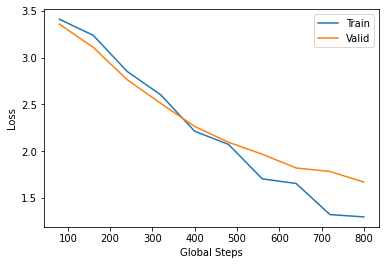

Model loaded from <== ./bertimbau_resp/7/metrics.pt


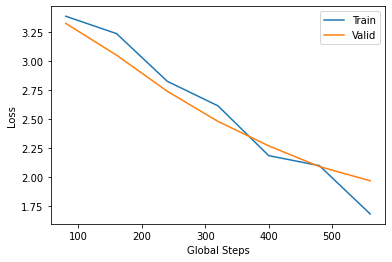

In [15]:
id_planilha = [1,7]
for id_ in id_planilha:
  file_path = destination_folder + "/"+str(id_)
  train_loss_list, valid_loss_list, global_steps_list = load_metrics(file_path + '/metrics.pt')
  plt.plot(global_steps_list, train_loss_list, label='Train')
  plt.plot(global_steps_list, valid_loss_list, label='Valid')
  plt.xlabel('Global Steps')
  plt.ylabel('Loss')
  plt.title = 'Resultado do Treino id ' + str(id_)
  plt.legend()
  plt.show() 

### Avaliação
* https://towardsdatascience.com/evaluating-categorical-models-e667e17987fd
* https://towardsdatascience.com/evaluating-categorical-models-ii-sensitivity-and-specificity-e181e573cff8
* https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5
* https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872
* Material de aula do Professor André
* Material do curso MicroSoft
* Predictive Accuracy: A Misleading Performance Measure for Highly Imbalanced Data (sas_metrics.pdf) Paper 942-2017 (Josephine S Akosa, Oklahoma State University)


VP = VERDADEIRO POSITIVO<br>
VN = VERDADEIRO NEGATIVO<br>
FP = FALSO POSITIVO<br>
FN = FALSON NEGATIVO<br>
TVP = TAXA DE VERDADEIRO POSITIVO<br>
TVN = TAXA DE VERDADEIRO NEGATIVO<br>
TFP = TAXA DE FALSO POSITIVO<br>
TFN = TAXA DE FALSO NEGATIVO<br>

Métricas utilizadas:<br>

* **Acurácia:** proporção de classificações corretas feitas pelo modelo.<br>
        Acurácia = (VP + VN)/(VP+VN+VP+VN)<br>

* **Precisão:** proporção correta de classificação feita para uma determinada classe.<br>
        Precisão = (VP)/(VP + FP)

* **Revocação ou Sensibilidade:** proporção de classificações corretas de VP feitas para uma determinada classe considerando todas as instâncias do dataset de testes.<br>
      Revocação = TVP = (VP)/(VP+FN)

* **Especificidade:** proporção de classificações corretas de VN feitas para uma determinada classe considerando todas as instâncias do dataset de testes.
      Especificidade = TVN = (VN)/(VN + FP)

* **Suporte:** quantidade de instâncias de uma determinada classe no dataset de testes.

**Para o DataSet 3 - dados desbalanceados**

* **F1 é a média harmônica da precisão e da revocação.<br>

      F1 = (2 * VP) / (2 * VP + FP + FN)
* **MCC:** é o coeficiente de correlação Matthews que é utilizado para classes com tamanhos diferentes. Possui escala entre -1 e 1, sendo que 1 indica uma perfeita predição, 0 representa uma predição aleatória e -1 indica discordância total dos valores preditos e os valores verdadeiros.  

      MCC = (VP*VN - FP*FN) / (SQRT(VP+FP)*(VP+FN)*(VN+FP)*(VN+FN)

* **Média Geométrica (G-mean)** é uma métrica que mede o equilíbrio entre o desempenho de classificação tanto na classe majoritária quanto na minoritária. Um índice baixo é uma indicação de mau desempenho na classificação dos casos positivos, mesmo que os casos negativos sejam corretamente classificados como tal. Ela é importante para prever o sobreajustamento da classe negativa e o subajustamento da classe positiva. Como nosso dataset não possui classes binárias, a fórmula de cálculo será como se segue (material de aula do Prof. André):

      G-mean = $(\pi_{i=1}^{c}Revocacao_{i})^{1/c}$ 




  



In [ ]:
def calcula_especificidade_porClasse(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = (VN)/(VN + FP)
  return TVN

In [32]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    n_classe = np.max(y_true)+1
    report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4)
    print('Acurácia balanceada:',balanced_accuracy_score(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe))
    print(cm)
    #ax= plt.subplot()
    #sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    #ax.set_title('Confusion Matrix')
    #ax.set_xlabel('Predicted Labels')
    #ax.set_ylabel('True Labels')
    return report


In [46]:
cm = evaluate(best_model, tokens[2])
calcula_especificidade_porClasse(cm)

Classification Report:
              precision    recall  f1-score   support

           0     0.7879    0.7959    0.7919        98
           1     0.5185    0.4719    0.4941        89
           2     0.7170    0.8000    0.7562        95
           3     0.9052    0.9545    0.9292       110
           4     0.7600    0.7917    0.7755        96
           5     0.7742    0.7423    0.7579        97
           6     0.7879    0.6964    0.7393       112
           7     0.7876    0.8558    0.8203       104
           8     0.8451    0.6593    0.7407        91
           9     0.7262    0.6421    0.6816        95
          10     0.9625    0.7549    0.8462       102
          11     0.8409    0.8506    0.8457        87
          12     0.9115    0.9035    0.9075       114
          13     0.7313    0.8673    0.7935       113
          14     0.8817    0.8542    0.8677        96
          15     0.6066    0.8315    0.7014        89
          16     0.8283    0.8119    0.8200       101
    

array([0.98766157, 0.97720631, 0.98240469, 0.99349112, 0.98591549,
       0.98766882, 0.98755924, 0.98584906, 0.99356349, 0.98651026,
       0.99823322, 0.9918272 , 0.9940688 , 0.97866034, 0.9935446 ,
       0.97194623, 0.98999411, 0.99585554])

In [35]:
cm

array([[ 78,   6,   5,   1,   0,   2,   0,   2,   0,   2,   0,   0,   0,
          1,   1,   0,   0,   0],
       [  3,  42,  14,   2,   2,   2,   2,   0,   1,  14,   0,   0,   0,
          1,   0,   4,   2,   0],
       [  5,   0,  76,   0,   1,   2,   0,   0,   0,   2,   0,   7,   0,
          0,   1,   1,   0,   0],
       [  0,   0,   0, 105,   0,   0,   1,   3,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   1,   0,   0,  76,   0,   4,   1,   0,   0,   0,   1,   1,
          6,   2,   4,   0,   0],
       [  3,   0,   1,   1,   1,  72,   1,   1,   2,   0,   0,   0,   4,
          6,   3,   2,   0,   0],
       [  0,   1,   0,   0,   1,   0,  78,   0,   5,   0,   1,   2,   0,
          0,   0,  24,   0,   0],
       [  1,   0,   1,   0,   0,   1,   0,  89,   0,   0,   0,   0,   2,
          3,   0,   0,   0,   7],
       [  5,   2,   2,   4,   2,   3,   4,   0,  60,   0,   1,   1,   1,
          1,   2,   1,   2,   0],
       [  2,  10,   2,   1,   6,   4,

In [20]:
#%%time    
qtd_categories=[18]
id_planilha = [6]
dataset = [2]
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
      print('id_planilha:', id_)
      tokens = tokenizaAmostra(source_folder+str(amostra))
      best_model =BERT(qtd_categories=qtd_categories[idx]).to(device)
      load_checkpoint(destination_folder+"/"+str(id_) + '/model.pt', best_model)
      evaluate(best_model, tokens[2])

id_planilha: 6


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/6/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.7879    0.7959    0.7919        98
           1     0.5185    0.4719    0.4941        89
           2     0.7170    0.8000    0.7562        95
           3     0.9052    0.9545    0.9292       110
           4     0.7600    0.7917    0.7755        96
           5     0.7742    0.7423    0.7579        97
           6     0.7879    0.6964    0.7393       112
           7     0.7876    0.8558    0.8203       104
           8     0.8451    0.6593    0.7407        91
           9     0.7262    0.6421    0.6816        95
          10     0.9625    0.7549    0.8462       102
          11     0.8409    0.8506    0.8457        87
          12     0.9115    0.9035    0.9075       114
          13     0.7313    0.8673    0.7935       113
          14     0.8817    0.8542    0.8677        96
          15     0.6066    0.8315    0.7014        89
        

NameError: ignored

In [ ]:
#!rm ./bertimbau_all_categ/amostra_4/*.*
#!du -sh
